In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [4]:
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [6]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)
train(nn_deep, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, test_loader, device)

# Instantiate the lightweight network:
torch.manual_seed(42)
nn_light = LightNN(num_classes=10).to(device)

Epoch 1/10, Loss: 1.330467386471341
Epoch 2/10, Loss: 0.8634735068396839
Epoch 3/10, Loss: 0.6844710632205924
Epoch 4/10, Loss: 0.5380034479491241
Epoch 5/10, Loss: 0.4240817621235957
Epoch 6/10, Loss: 0.3213324511752409
Epoch 7/10, Loss: 0.23568803894207302
Epoch 8/10, Loss: 0.1779426922807303
Epoch 9/10, Loss: 0.14223444915336111
Epoch 10/10, Loss: 0.11729498422416428
Test Accuracy: 75.27%


In [7]:
torch.manual_seed(42)
new_nn_light = LightNN(num_classes=10).to(device)

In [8]:
# Print the norm of the first layer of the initial lightweight model
print("Norm of 1st layer of nn_light:", torch.norm(nn_light.features[0].weight).item())
# Print the norm of the first layer of the new lightweight model
print("Norm of 1st layer of new_nn_light:", torch.norm(new_nn_light.features[0].weight).item())

Norm of 1st layer of nn_light: 2.327361822128296
Norm of 1st layer of new_nn_light: 2.327361822128296


In [9]:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNN parameters: {total_params_light}")

DeepNN parameters: 1,186,986
LightNN parameters: 267,738


In [10]:
train(nn_light, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_light_ce = test(nn_light, test_loader, device)

Epoch 1/10, Loss: 1.4701128649284771
Epoch 2/10, Loss: 1.1597599091432285
Epoch 3/10, Loss: 1.0226381463772805
Epoch 4/10, Loss: 0.9181029537449712
Epoch 5/10, Loss: 0.8436743356382755
Epoch 6/10, Loss: 0.7742246528110845
Epoch 7/10, Loss: 0.7095077499709166
Epoch 8/10, Loss: 0.654213540313189
Epoch 9/10, Loss: 0.6011876303064244
Epoch 10/10, Loss: 0.5517480510579961
Test Accuracy: 70.67%


In [11]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy: {test_accuracy_light_ce:.2f}%")

Teacher accuracy: 75.27%
Student accuracy: 70.67%


In [12]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(teacher=nn_deep, student=new_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_kd = test(new_nn_light, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Epoch 1/10, Loss: 2.391380796042245
Epoch 2/10, Loss: 1.874644519422975
Epoch 3/10, Loss: 1.645540188950346
Epoch 4/10, Loss: 1.4856545098907197
Epoch 5/10, Loss: 1.3589384804296372
Epoch 6/10, Loss: 1.242716954492242
Epoch 7/10, Loss: 1.1491652713407337
Epoch 8/10, Loss: 1.0668155057046114
Epoch 9/10, Loss: 0.9929231547028817
Epoch 10/10, Loss: 0.9258563126749395
Test Accuracy: 70.39%
Teacher accuracy: 75.27%
Student accuracy without teacher: 70.67%
Student accuracy with CE + KD: 70.39%


In [13]:
#COSINE RUN

In [14]:
class ModifiedDeepNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        flattened_conv_output_after_pooling = torch.nn.functional.avg_pool1d(flattened_conv_output, 2)
        return x, flattened_conv_output_after_pooling

# Create a similar student class where we return a tuple. We do not apply pooling after flattening.
class ModifiedLightNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        return x, flattened_conv_output

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep = ModifiedDeepNNCosine(num_classes=10).to(device)
modified_nn_deep.load_state_dict(nn_deep.state_dict())

# Once again ensure the norm of the first layer is the same for both networks
print("Norm of 1st layer for deep_nn:", torch.norm(nn_deep.features[0].weight).item())
print("Norm of 1st layer for modified_deep_nn:", torch.norm(modified_nn_deep.features[0].weight).item())

# Initialize a modified lightweight network with the same seed as our other lightweight instances. This will be trained from scratch to examine the effectiveness of cosine loss minimization.
torch.manual_seed(42)
modified_nn_light = ModifiedLightNNCosine(num_classes=10).to(device)
print("Norm of 1st layer:", torch.norm(modified_nn_light.features[0].weight).item())

Norm of 1st layer for deep_nn: 7.500118732452393
Norm of 1st layer for modified_deep_nn: 7.500118732452393
Norm of 1st layer: 2.327361822128296


In [15]:
# Create a sample input tensor
sample_input = torch.randn(128, 3, 32, 32).to(device) # Batch size: 128, Filters: 3, Image size: 32x32

# Pass the input through the student
logits, hidden_representation = modified_nn_light(sample_input)

# Print the shapes of the tensors
print("Student logits shape:", logits.shape) # batch_size x total_classes
print("Student hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

# Pass the input through the teacher
logits, hidden_representation = modified_nn_deep(sample_input)

# Print the shapes of the tensors
print("Teacher logits shape:", logits.shape) # batch_size x total_classes
print("Teacher hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

Student logits shape: torch.Size([128, 10])
Student hidden representation shape: torch.Size([128, 1024])
Teacher logits shape: torch.Size([128, 10])
Teacher hidden representation shape: torch.Size([128, 1024])


In [16]:
def train_cosine_loss(teacher, student, train_loader, epochs, learning_rate, hidden_rep_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    cosine_loss = nn.CosineEmbeddingLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model and keep only the hidden representation
            with torch.no_grad():
                _, teacher_hidden_representation = teacher(inputs)

            # Forward pass with the student model
            student_logits, student_hidden_representation = student(inputs)

            # Calculate the cosine loss. Target is a vector of ones. From the loss formula above we can see that is the case where loss minimization leads to cosine similarity increase.
            hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(inputs.size(0)).to(device))

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [17]:
def test_multiple_outputs(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs) # Disregard the second tensor of the tuple
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [18]:
# Train and test the lightweight network with cross entropy loss
train_cosine_loss(teacher=modified_nn_deep, student=modified_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, hidden_rep_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_cosine_loss = test_multiple_outputs(modified_nn_light, test_loader, device)

Epoch 1/10, Loss: 1.3057697980910006
Epoch 2/10, Loss: 1.0745299618567348
Epoch 3/10, Loss: 0.9738363100744575
Epoch 4/10, Loss: 0.8982713227076908
Epoch 5/10, Loss: 0.8415237082849683
Epoch 6/10, Loss: 0.7956077659221561
Epoch 7/10, Loss: 0.7542956925718985
Epoch 8/10, Loss: 0.7177903902195298
Epoch 9/10, Loss: 0.6814029283840638
Epoch 10/10, Loss: 0.655689008476789
Test Accuracy: 70.87%


In [19]:
# Intermediate Regressor Run

In [20]:
# Pass the sample input only from the convolutional feature extractor
convolutional_fe_output_student = nn_light.features(sample_input)
convolutional_fe_output_teacher = nn_deep.features(sample_input)

# Print their shapes
print("Student's feature extractor output shape: ", convolutional_fe_output_student.shape)
print("Teacher's feature extractor output shape: ", convolutional_fe_output_teacher.shape)

Student's feature extractor output shape:  torch.Size([128, 16, 8, 8])
Teacher's feature extractor output shape:  torch.Size([128, 32, 8, 8])


In [21]:
class ModifiedDeepNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        conv_feature_map = x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map

class ModifiedLightNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Include an extra regressor (in our case linear)
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        regressor_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output

In [22]:
def train_mse_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Again ignore teacher logits
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)

            # Forward pass with the student model
            student_logits, regressor_feature_map = student(inputs)

            # Calculate the loss
            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Notice how our test function remains the same here with the one we used in our previous case. We only care about the actual outputs because we measure accuracy.

# Initialize a ModifiedLightNNRegressor
torch.manual_seed(42)
modified_nn_light_reg = ModifiedLightNNRegressor(num_classes=10).to(device)

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep_reg = ModifiedDeepNNRegressor(num_classes=10).to(device)
modified_nn_deep_reg.load_state_dict(nn_deep.state_dict())

# Train and test once again
train_mse_loss(teacher=modified_nn_deep_reg, student=modified_nn_light_reg, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_mse_loss = test_multiple_outputs(modified_nn_light_reg, test_loader, device)

Epoch 1/10, Loss: 1.7154668968961673
Epoch 2/10, Loss: 1.3335056149441262
Epoch 3/10, Loss: 1.1886501702506218
Epoch 4/10, Loss: 1.094390550995117
Epoch 5/10, Loss: 1.0165000830769844
Epoch 6/10, Loss: 0.9551097375657552
Epoch 7/10, Loss: 0.9048605158810725
Epoch 8/10, Loss: 0.8542215229605165
Epoch 9/10, Loss: 0.8138036415400103
Epoch 10/10, Loss: 0.7756401430005613
Test Accuracy: 70.30%


In [23]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")
print(f"Student accuracy with CE + CosineLoss: {test_accuracy_light_ce_and_cosine_loss:.2f}%")
print(f"Student accuracy with CE + RegressorMSE: {test_accuracy_light_ce_and_mse_loss:.2f}%")

Teacher accuracy: 75.27%
Student accuracy without teacher: 70.67%
Student accuracy with CE + KD: 70.39%
Student accuracy with CE + CosineLoss: 70.87%
Student accuracy with CE + RegressorMSE: 70.30%


In [ ]:
##########################################################################################################

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the CIFAR-10 dataset
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset_full = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

# Split the dataset into two tasks
task1_classes = [0, 1, 2, 3, 4]  # 'airplane', 'automobile', 'bird', 'cat', 'deer'
task2_classes = [5, 6, 7, 8, 9]  # 'dog', 'frog', 'horse', 'ship', 'truck'

# Get indices for each task
train_indices_task1 = [i for i, label in enumerate(train_dataset_full.targets) if label in task1_classes]
train_indices_task2 = [i for i, label in enumerate(train_dataset_full.targets) if label in task2_classes]

test_indices_task1 = [i for i, label in enumerate(test_dataset_full.targets) if label in task1_classes]
test_indices_task2 = [i for i, label in enumerate(test_dataset_full.targets) if label in task2_classes]

# Define label mappings for each task
label_mapping_task1 = {label: idx for idx, label in enumerate(task1_classes)}
label_mapping_task2 = {label: idx for idx, label in enumerate(task2_classes)}

# Custom dataset class that remaps labels
class SubsetRemapLabels(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, label_mapping):
        self.dataset = dataset
        self.indices = indices
        self.label_mapping = label_mapping

    def __getitem__(self, idx):
        data, target = self.dataset[self.indices[idx]]
        target = self.label_mapping[target]
        return data, target

    def __len__(self):
        return len(self.indices)

# Create datasets for each task
train_dataset_task1 = SubsetRemapLabels(train_dataset_full, train_indices_task1, label_mapping_task1)
train_dataset_task2 = SubsetRemapLabels(train_dataset_full, train_indices_task2, label_mapping_task2)

test_dataset_task1 = SubsetRemapLabels(test_dataset_full, test_indices_task1, label_mapping_task1)
test_dataset_task2 = SubsetRemapLabels(test_dataset_full, test_indices_task2, label_mapping_task2)

# Create data loaders
train_loader_task1 = torch.utils.data.DataLoader(train_dataset_task1, batch_size=128, shuffle=True, num_workers=0)
train_loader_task2 = torch.utils.data.DataLoader(train_dataset_task2, batch_size=128, shuffle=True, num_workers=0)

test_loader_task1 = torch.utils.data.DataLoader(test_dataset_task1, batch_size=128, shuffle=False, num_workers=0)
test_loader_task2 = torch.utils.data.DataLoader(test_dataset_task2, batch_size=128, shuffle=False, num_workers=0)




Files already downloaded and verified
Files already downloaded and verified


In [2]:
print(f'Task 1 training samples: {len(train_dataset_task1)}')
print(f'Task 1 test samples: {len(test_dataset_task1)}')
print(f'Task 2 training samples: {len(train_dataset_task2)}')
print(f'Task 2 test samples: {len(test_dataset_task2)}')


Task 1 training samples: 25000
Task 1 test samples: 5000
Task 2 training samples: 25000
Task 2 test samples: 5000


In [3]:
from collections import Counter

def print_label_distribution(dataset, dataset_name):
    labels = []
    for _, label in dataset:
        labels.append(label)
    label_counts = Counter(labels)
    print(f"Label distribution in {dataset_name}:")
    for label, count in sorted(label_counts.items()):
        print(f"  Label {label}: {count} samples")
    print()

# Print label distribution for each dataset
print_label_distribution(train_dataset_task1, "Task 1 Training Set")
print_label_distribution(test_dataset_task1, "Task 1 Test Set")
print_label_distribution(train_dataset_task2, "Task 2 Training Set")
print_label_distribution(test_dataset_task2, "Task 2 Test Set")


Label distribution in Task 1 Training Set:
  Label 0: 5000 samples
  Label 1: 5000 samples
  Label 2: 5000 samples
  Label 3: 5000 samples
  Label 4: 5000 samples

Label distribution in Task 1 Test Set:
  Label 0: 1000 samples
  Label 1: 1000 samples
  Label 2: 1000 samples
  Label 3: 1000 samples
  Label 4: 1000 samples

Label distribution in Task 2 Training Set:
  Label 0: 5000 samples
  Label 1: 5000 samples
  Label 2: 5000 samples
  Label 3: 5000 samples
  Label 4: 5000 samples

Label distribution in Task 2 Test Set:
  Label 0: 1000 samples
  Label 1: 1000 samples
  Label 2: 1000 samples
  Label 3: 1000 samples
  Label 4: 1000 samples



In [4]:
# Function to unnormalize and display an image
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])  # Mean used in normalization
    std = np.array([0.229, 0.224, 0.225])   # Std used in normalization
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Function to display a batch of images
def show_batch(dataset, dataset_name, class_names, num_images=5, label_mapping=None):
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True, num_workers=0)
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    plt.figure(figsize=(15, 5))
    for idx in range(num_images):
        label_idx = labels[idx].item()
        # Map label back to original if necessary
        if label_mapping:
            original_label = label_mapping[label_idx]
            title = class_names[original_label]
        else:
            title = class_names[label_idx]
        imshow(images[idx], title=title)
    plt.suptitle(dataset_name)
    plt.show()


In [5]:
# Original CIFAR-10 class names
original_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck']

# Class names for Task 1 and Task 2
task1_classes = [0, 1, 2, 3, 4]
task2_classes = [5, 6, 7, 8, 9]

# Create reverse label mappings
reverse_label_mapping_task1 = {v: k for k, v in label_mapping_task1.items()}
reverse_label_mapping_task2 = {v: k for k, v in label_mapping_task2.items()}


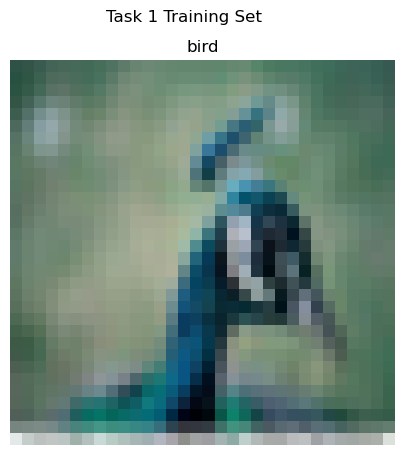

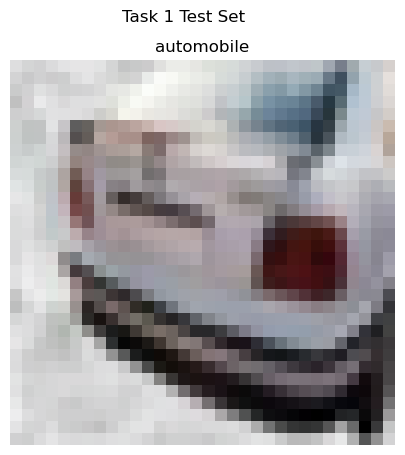

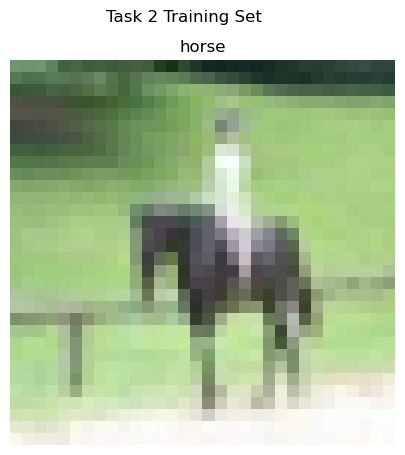

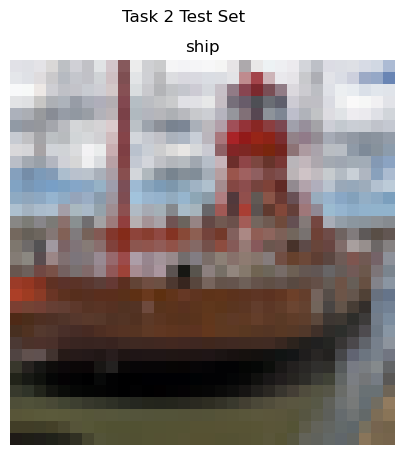

In [6]:
# Task 1 Training Set
show_batch(train_dataset_task1, "Task 1 Training Set", original_class_names, label_mapping=reverse_label_mapping_task1)

# Task 1 Test Set
show_batch(test_dataset_task1, "Task 1 Test Set", original_class_names, label_mapping=reverse_label_mapping_task1)

# Task 2 Training Set
show_batch(train_dataset_task2, "Task 2 Training Set", original_class_names, label_mapping=reverse_label_mapping_task2)

# Task 2 Test Set
show_batch(test_dataset_task2, "Task 2 Test Set", original_class_names, label_mapping=reverse_label_mapping_task2)


In [7]:
# Define DeepNN and LightNN models with intermediate features
class DeepNN(nn.Module):
    def __init__(self, num_classes=5):
        super(DeepNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(2048, 512)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        f1 = x
        x = self.conv2(x)
        x = self.relu2(x)
        f2 = x
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.relu3(x)
        f3 = x
        x = self.conv4(x)
        x = self.relu4(x)
        f4 = x
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x, [f1, f2, f3, f4]

class LightNN(nn.Module):
    def __init__(self, num_classes=5):
        super(LightNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(1024, 256)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Matching layers to adjust feature dimensions
        self.match_conv1 = nn.Conv2d(16, 128, kernel_size=1)  # To match teacher's conv1 output
        self.match_conv2 = nn.Conv2d(16, 64, kernel_size=1)   # To match teacher's conv2 output

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        f1 = self.match_conv1(x)  # Adjusted feature map
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        f2 = self.match_conv2(x)  # Adjusted feature map
        x = self.pool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x, [f1, f2]


# Training and testing functions
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [8]:
# Train the teacher model on Task 1
torch.manual_seed(42)
teacher_model = DeepNN(num_classes=5).to(device)
train(teacher_model, train_loader_task1, epochs=10, learning_rate=0.001, device=device)


Epoch 1/10, Loss: 0.9994
Epoch 2/10, Loss: 0.6885
Epoch 3/10, Loss: 0.5523
Epoch 4/10, Loss: 0.4565
Epoch 5/10, Loss: 0.3614
Epoch 6/10, Loss: 0.2793
Epoch 7/10, Loss: 0.2041
Epoch 8/10, Loss: 0.1408
Epoch 9/10, Loss: 0.1038
Epoch 10/10, Loss: 0.0767


In [9]:
# Evaluate the teacher model
test_accuracy_task1_teacher = test(teacher_model, test_loader_task1, device)
test_accuracy_task2_teacher = test(teacher_model, test_loader_task2, device)

print(f"Teacher model accuracy on Task 1 test set: {test_accuracy_task1_teacher:.2f}%")
print(f"Teacher model accuracy on Task 2 test set: {test_accuracy_task2_teacher:.2f}%")


Teacher model accuracy on Task 1 test set: 82.16%
Teacher model accuracy on Task 2 test set: 6.32%


In [10]:
# Define the student models
torch.manual_seed(42)
student_model_baseline = LightNN(num_classes=5).to(device)
student_model_single = LightNN(num_classes=5).to(device)
student_model_multi = LightNN(num_classes=5).to(device)

# Train the baseline student model on Task 2 data only
train(student_model_baseline, train_loader_task2, epochs=10, learning_rate=0.001, device=device)

Epoch 1/10, Loss: 0.8580
Epoch 2/10, Loss: 0.5952
Epoch 3/10, Loss: 0.5102
Epoch 4/10, Loss: 0.4471
Epoch 5/10, Loss: 0.4033
Epoch 6/10, Loss: 0.3599
Epoch 7/10, Loss: 0.3318
Epoch 8/10, Loss: 0.2939
Epoch 9/10, Loss: 0.2685
Epoch 10/10, Loss: 0.2442


In [11]:
# Evaluate the baseline student model
test_accuracy_task1_student_baseline = test(student_model_baseline, test_loader_task1, device)
test_accuracy_task2_student_baseline = test(student_model_baseline, test_loader_task2, device)

print(f"Baseline student model accuracy on Task 1 test set: {test_accuracy_task1_student_baseline:.2f}%")
print(f"Baseline student model accuracy on Task 2 test set: {test_accuracy_task2_student_baseline:.2f}%")

Baseline student model accuracy on Task 1 test set: 8.52%
Baseline student model accuracy on Task 2 test set: 85.68%


In [13]:
# Knowledge distillation training functions
def train_single_level_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, device, alpha=0.5, temperature=2):
    ce_loss_fn = nn.CrossEntropyLoss()
    kl_loss_fn = nn.KLDivLoss(reduction='batchmean')
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Teacher outputs
            with torch.no_grad():
                teacher_outputs, _ = teacher(inputs)

            # Student outputs
            student_outputs, _ = student(inputs)

            # Loss calculations
            loss_ce = ce_loss_fn(student_outputs, labels)
            loss_kd = kl_loss_fn(
                nn.functional.log_softmax(student_outputs / temperature, dim=1),
                nn.functional.softmax(teacher_outputs / temperature, dim=1)
            ) * (temperature ** 2)

            loss = alpha * loss_ce + (1 - alpha) * loss_kd

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

def train_multilevel_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, device, alpha=0.5, beta=0.5, temperature=2):
    ce_loss_fn = nn.CrossEntropyLoss()
    kl_loss_fn = nn.KLDivLoss(reduction='batchmean')
    mse_loss_fn = nn.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Teacher outputs and features
            with torch.no_grad():
                teacher_outputs, teacher_features = teacher(inputs)

            # Student outputs and features
            student_outputs, student_features = student(inputs)

            # Loss calculations
            loss_ce = ce_loss_fn(student_outputs, labels)
            loss_kd = kl_loss_fn(
                nn.functional.log_softmax(student_outputs / temperature, dim=1),
                nn.functional.softmax(teacher_outputs / temperature, dim=1)
            ) * (temperature ** 2)

            # MSE loss for intermediate features
            loss_mse = 0.0
            for t_feat, s_feat in zip(teacher_features, student_features):
                # Ensure spatial dimensions match
                if s_feat.shape[2:] != t_feat.shape[2:]:
                    s_feat = nn.functional.interpolate(s_feat, size=t_feat.shape[2:], mode='bilinear', align_corners=False)
                loss_mse += mse_loss_fn(s_feat, t_feat.detach())

            # Combine losses
            loss = alpha * loss_ce + (1 - alpha) * (beta * loss_kd + (1 - beta) * loss_mse)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Train the student model with single-level knowledge distillation
train_single_level_knowledge_distillation(teacher_model, student_model_single, train_loader_task2, epochs=10, learning_rate=0.001, device=device)

Epoch 1/10, Loss: 2.5424
Epoch 2/10, Loss: 2.2768
Epoch 3/10, Loss: 2.1571
Epoch 4/10, Loss: 2.0858
Epoch 5/10, Loss: 2.0245
Epoch 6/10, Loss: 1.9867
Epoch 7/10, Loss: 1.9434
Epoch 8/10, Loss: 1.9089
Epoch 9/10, Loss: 1.8682
Epoch 10/10, Loss: 1.8363


In [14]:
# Evaluate the student model with single-level distillation
test_accuracy_task1_student_single = test(student_model_single, test_loader_task1, device)
test_accuracy_task2_student_single = test(student_model_single, test_loader_task2, device)

print(f"Student model (single-level KD) accuracy on Task 1 test set: {test_accuracy_task1_student_single:.2f}%")
print(f"Student model (single-level KD) accuracy on Task 2 test set: {test_accuracy_task2_student_single:.2f}%")

Student model (single-level KD) accuracy on Task 1 test set: 66.80%
Student model (single-level KD) accuracy on Task 2 test set: 28.94%


In [15]:
# Train the student model with multi-level knowledge distillation
# Train the student model with multi-level knowledge distillation
train_multilevel_knowledge_distillation(
    teacher_model, 
    student_model_multi, 
    train_loader_task2, 
    epochs=10, 
    learning_rate=0.001, 
    device=device
)


Epoch 1/10, Loss: 1.4206
Epoch 2/10, Loss: 1.3821
Epoch 3/10, Loss: 1.3544
Epoch 4/10, Loss: 1.3302
Epoch 5/10, Loss: 1.3069
Epoch 6/10, Loss: 1.2827
Epoch 7/10, Loss: 1.2631
Epoch 8/10, Loss: 1.2467
Epoch 9/10, Loss: 1.2255
Epoch 10/10, Loss: 1.2106


In [16]:
# Evaluate the student model with multi-level distillation
test_accuracy_task1_student_multi = test(student_model_multi, test_loader_task1, device)
test_accuracy_task2_student_multi = test(student_model_multi, test_loader_task2, device)

print(f"Student model (multi-level KD) accuracy on Task 1 test set: {test_accuracy_task1_student_multi:.2f}%")
print(f"Student model (multi-level KD) accuracy on Task 2 test set: {test_accuracy_task2_student_multi:.2f}%")

# Compare the accuracies
print("\nAccuracy Comparison:")
print(f"Teacher model accuracy on Task 1: {test_accuracy_task1_teacher:.2f}%")
print(f"Teacher model accuracy on Task 2: {test_accuracy_task2_teacher:.2f}%\n")

print(f"Baseline student model accuracy on Task 1: {test_accuracy_task1_student_baseline:.2f}%")
print(f"Baseline student model accuracy on Task 2: {test_accuracy_task2_student_baseline:.2f}%\n")

print(f"Student model (single-level KD) accuracy on Task 1: {test_accuracy_task1_student_single:.2f}%")
print(f"Student model (single-level KD) accuracy on Task 2: {test_accuracy_task2_student_single:.2f}%\n")

print(f"Student model (multi-level KD) accuracy on Task 1: {test_accuracy_task1_student_multi:.2f}%")
print(f"Student model (multi-level KD) accuracy on Task 2: {test_accuracy_task2_student_multi:.2f}%")

Student model (multi-level KD) accuracy on Task 1 test set: 49.12%
Student model (multi-level KD) accuracy on Task 2 test set: 63.74%

Accuracy Comparison:
Teacher model accuracy on Task 1: 82.16%
Teacher model accuracy on Task 2: 6.32%

Baseline student model accuracy on Task 1: 8.52%
Baseline student model accuracy on Task 2: 85.68%

Student model (single-level KD) accuracy on Task 1: 66.80%
Student model (single-level KD) accuracy on Task 2: 28.94%

Student model (multi-level KD) accuracy on Task 1: 49.12%
Student model (multi-level KD) accuracy on Task 2: 63.74%


Confusion Matrices:


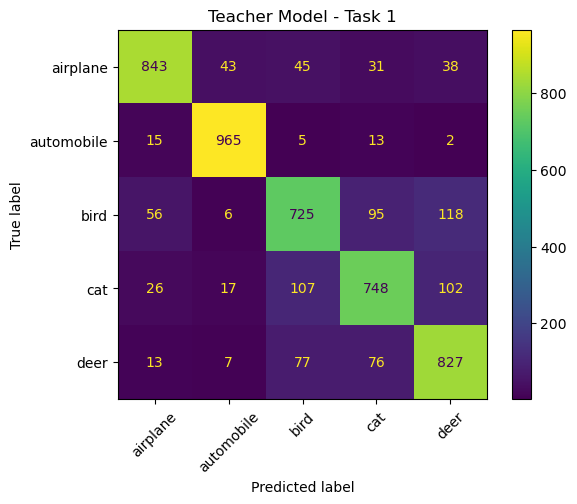

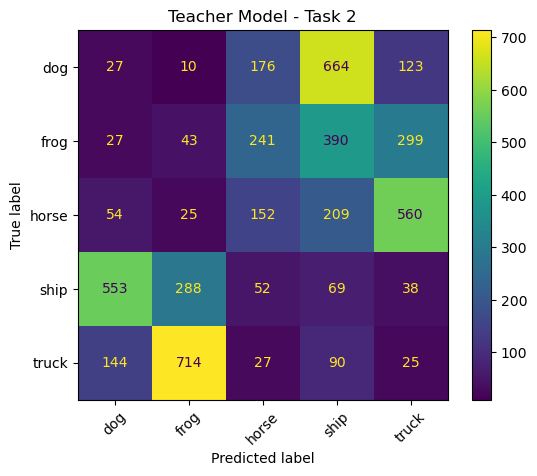

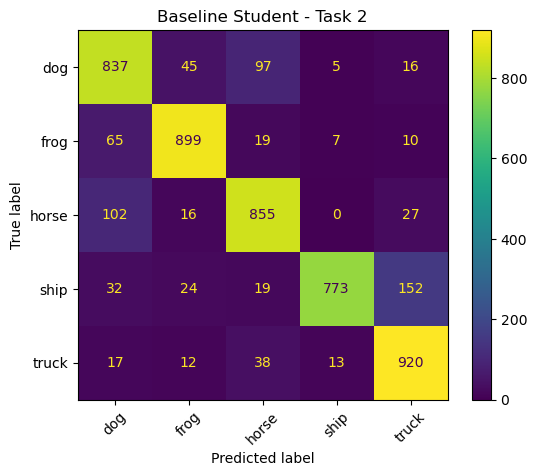

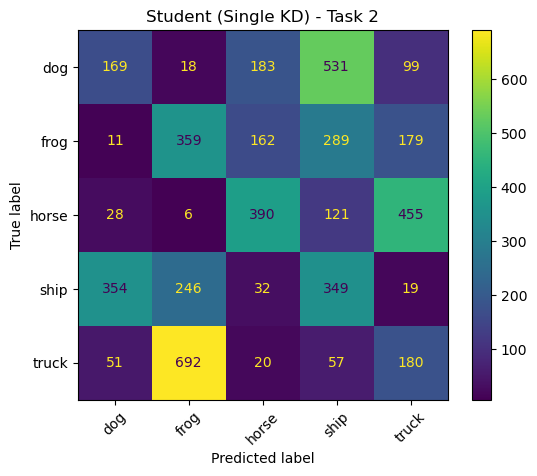

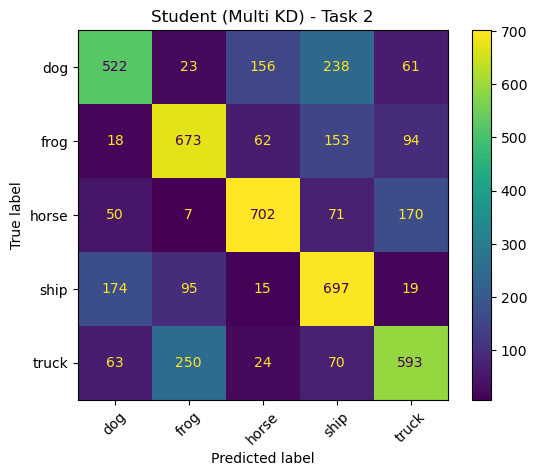

Accuracy Comparison:


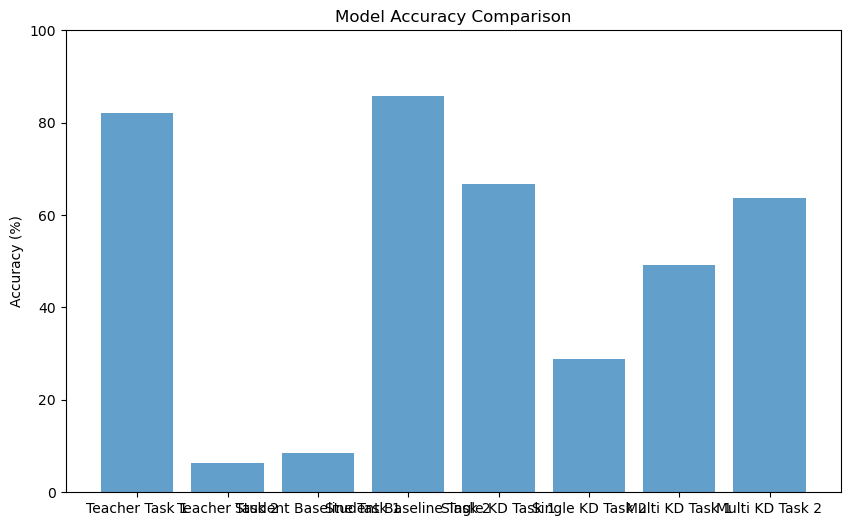

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(model, test_loader, class_names, device, title):
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title(title)
    plt.show()

# Function to plot accuracy comparison
def plot_accuracy_comparison(accuracies, model_names, title):
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, alpha=0.7)
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.ylim(0, 100)
    plt.show()

# CIFAR-10 class names for Task 1 and Task 2
task1_class_names = [original_class_names[idx] for idx in task1_classes]
task2_class_names = [original_class_names[idx] for idx in task2_classes]

# Visualize confusion matrices
print("Confusion Matrices:")
plot_confusion_matrix(teacher_model, test_loader_task1, task1_class_names, device, "Teacher Model - Task 1")
plot_confusion_matrix(teacher_model, test_loader_task2, task2_class_names, device, "Teacher Model - Task 2")
plot_confusion_matrix(student_model_baseline, test_loader_task2, task2_class_names, device, "Baseline Student - Task 2")
plot_confusion_matrix(student_model_single, test_loader_task2, task2_class_names, device, "Student (Single KD) - Task 2")
plot_confusion_matrix(student_model_multi, test_loader_task2, task2_class_names, device, "Student (Multi KD) - Task 2")

# Plot accuracy comparison
model_names = [
    "Teacher Task 1",
    "Teacher Task 2",
    "Student Baseline Task 1",
    "Student Baseline Task 2",
    "Single KD Task 1",
    "Single KD Task 2",
    "Multi KD Task 1",
    "Multi KD Task 2"
]

accuracies = [
    test_accuracy_task1_teacher,
    test_accuracy_task2_teacher,
    test_accuracy_task1_student_baseline,
    test_accuracy_task2_student_baseline,
    test_accuracy_task1_student_single,
    test_accuracy_task2_student_single,
    test_accuracy_task1_student_multi,
    test_accuracy_task2_student_multi
]

print("Accuracy Comparison:")
plot_accuracy_comparison(accuracies, model_names, "Model Accuracy Comparison")


Example Predictions:


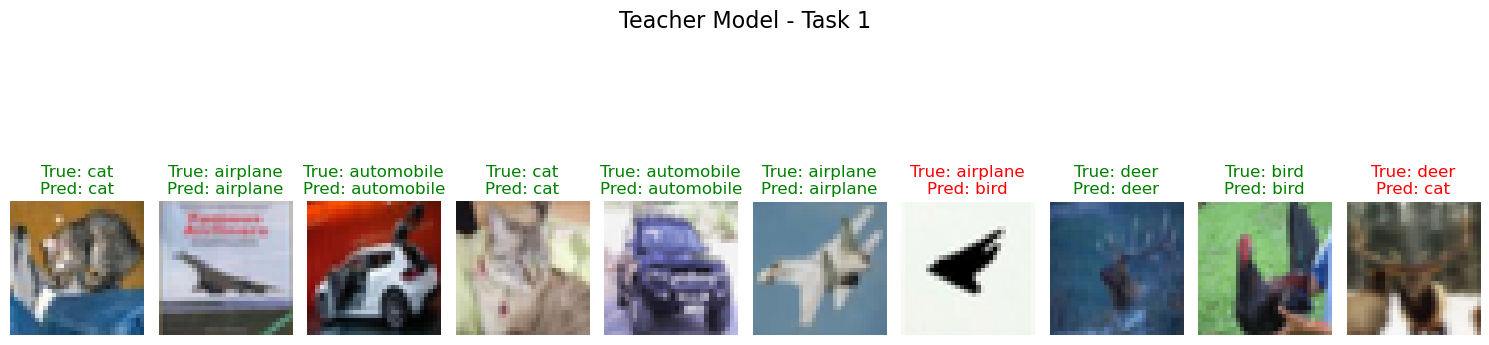

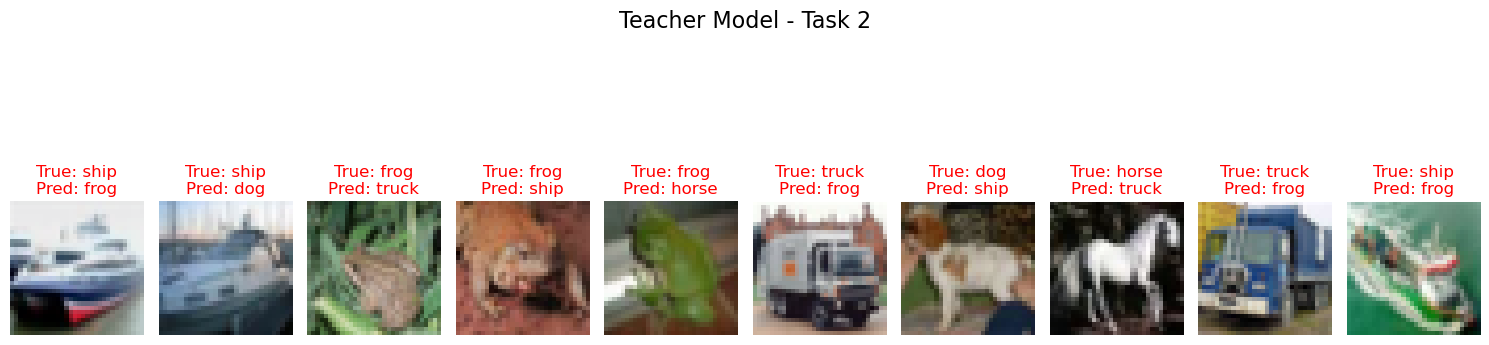

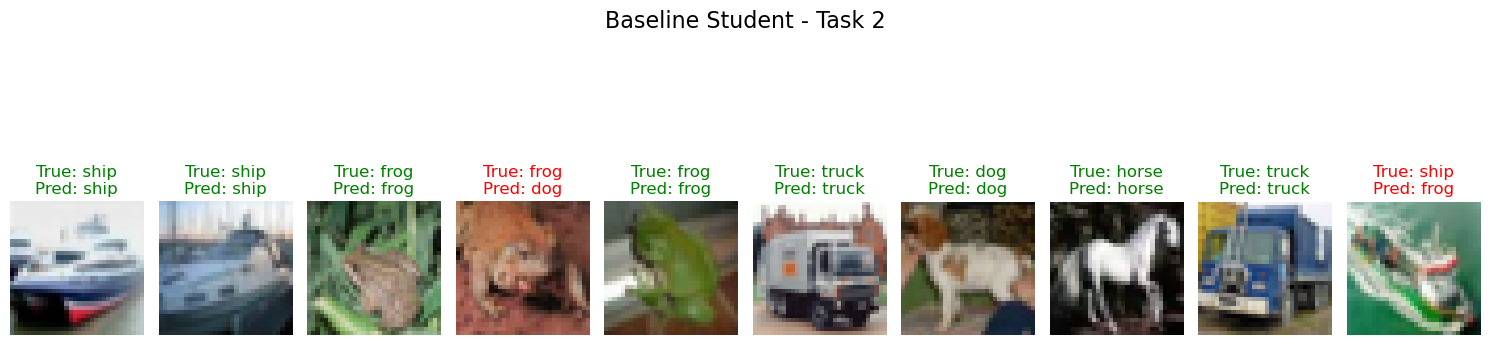

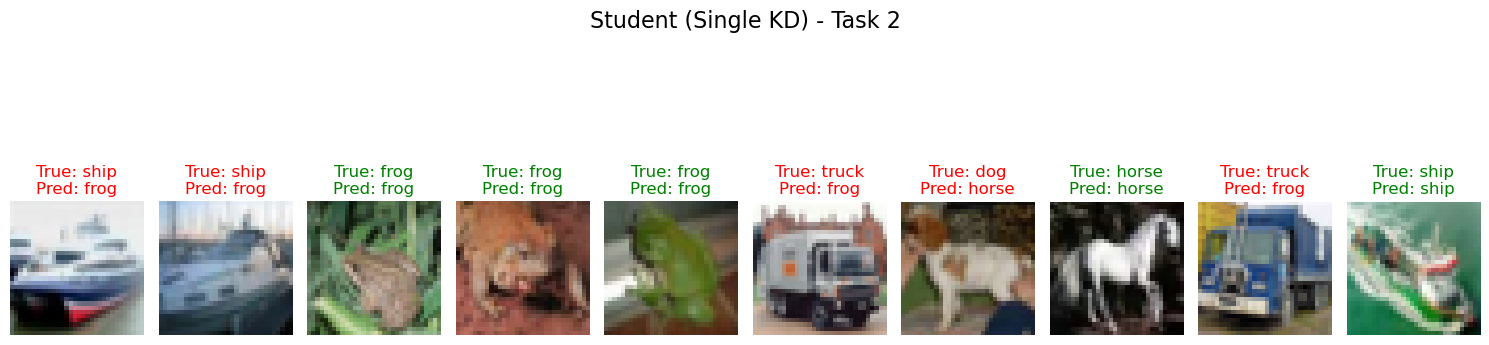

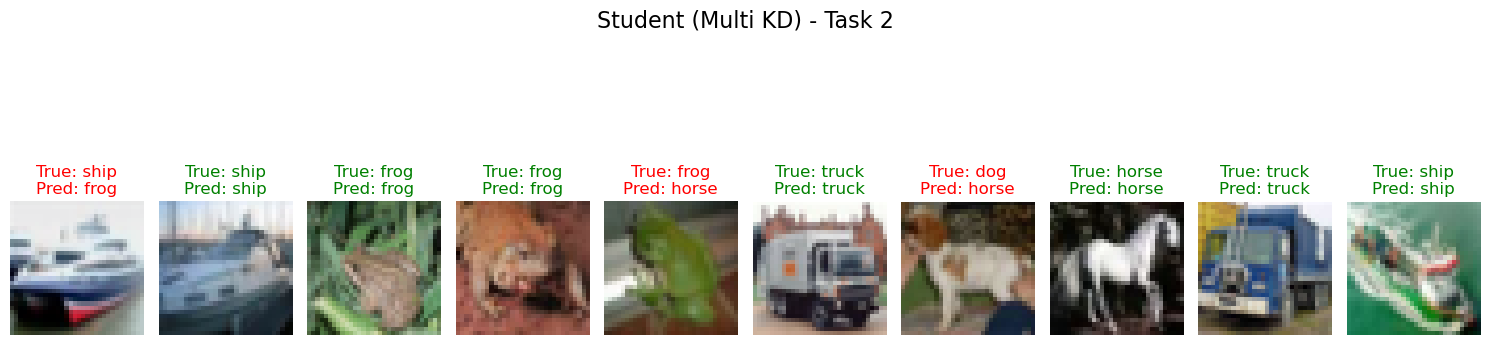

In [20]:
def plot_test_predictions(model, test_loader, class_names, device, title, num_images=10):
    model.to(device)
    model.eval()

    # Prepare to collect test images, ground truth, and predictions
    images, true_labels, predicted_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Collect up to num_images examples
            for i in range(len(labels)):
                if len(images) < num_images:
                    images.append(inputs[i].cpu())
                    true_labels.append(labels[i].item())
                    predicted_labels.append(predictions[i].item())
                else:
                    break
            if len(images) >= num_images:
                break

    # Plot the images with true and predicted labels
    plt.figure(figsize=(15, 5))
    for idx in range(num_images):
        plt.subplot(1, num_images, idx + 1)
        img = images[idx].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])  # Unnormalize
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        true_label = class_names[true_labels[idx]]
        predicted_label = class_names[predicted_labels[idx]]
        color = "green" if true_labels[idx] == predicted_labels[idx] else "red"

        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display example predictions for each model
print("Example Predictions:")
plot_test_predictions(teacher_model, test_loader_task1, task1_class_names, device, "Teacher Model - Task 1")
plot_test_predictions(teacher_model, test_loader_task2, task2_class_names, device, "Teacher Model - Task 2")
plot_test_predictions(student_model_baseline, test_loader_task2, task2_class_names, device, "Baseline Student - Task 2")
plot_test_predictions(student_model_single, test_loader_task2, task2_class_names, device, "Student (Single KD) - Task 2")
plot_test_predictions(student_model_multi, test_loader_task2, task2_class_names, device, "Student (Multi KD) - Task 2")
